In [143]:
# Import all necessary libraries
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For SQL queries
import sqlite3

# For interactive folium map
import folium
from folium.plugins import HeatMap

# For plotly dashboard
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px

# For the machine learning model
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
import seaborn as sns

In [68]:
# Access SpaceX API
base_url = "https://api.spacexdata.com/v4"
launches_url = f"{base_url}/launches"

# Fetch data from the SpaceX launches endpoint
response = requests.get(launches_url)

# Check if the request was successful
if response.status_code == 200:
    launches_data = response.json()
    print("Data fetched successfully!")
else:
    print(f"Failed to fetch data. Status code: {response.status_code}")
    launches_data = []

Data fetched successfully!


In [69]:
# Normalize and Load Data into DataFrame
df = pd.json_normalize(launches_data)

## Basic EDA

In [115]:
# Display basic information about the dataset
print("Data Summary:")
print(df.info())

Data Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   flight_number  205 non-null    int64 
 1   name           205 non-null    object
 2   rocket         205 non-null    object
 3   launchpad      205 non-null    object
 4   success        186 non-null    object
 5   date_utc       205 non-null    object
 6   payload_count  205 non-null    int64 
dtypes: int64(2), object(5)
memory usage: 11.3+ KB
None


In [71]:

# Display first few rows
print("First 5 rows:")
print(df.head())

# Select relevant columns for EDA
eda_columns = ['name', 'date_utc', 'success', 'rocket', 'payloads', 'launchpad', 'flight_number']
df_eda = df[eda_columns]

# Convert date to datetime
df_eda['date_utc'] = pd.to_datetime(df_eda['date_utc'])

First 5 rows:
       static_fire_date_utc  static_fire_date_unix    net  window  \
0  2006-03-17T00:00:00.000Z           1.142554e+09  False     0.0   
1                      None                    NaN  False     0.0   
2                      None                    NaN  False     0.0   
3  2008-09-20T00:00:00.000Z           1.221869e+09  False     0.0   
4                      None                    NaN  False     0.0   

                     rocket success  \
0  5e9d0d95eda69955f709d1eb   False   
1  5e9d0d95eda69955f709d1eb   False   
2  5e9d0d95eda69955f709d1eb   False   
3  5e9d0d95eda69955f709d1eb    True   
4  5e9d0d95eda69955f709d1eb    True   

                                            failures  \
0  [{'time': 33, 'altitude': None, 'reason': 'mer...   
1  [{'time': 301, 'altitude': 289, 'reason': 'har...   
2  [{'time': 140, 'altitude': 35, 'reason': 'resi...   
3                                                 []   
4                                                 []   


/var/folders/0n/7zh_5ys15qg_3mxxvd5rmfhh0000gn/T/ipykernel_6420/3643443814.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [111]:
# Calculate the total payload carried by boosters from NASA 

# Fetch data from SpaceX API
launches_data = requests.get(launches_url).json()
payloads_data = requests.get(payloads_url).json()

# Step 2: Normalize data
df_launches = pd.json_normalize(launches_data)
df_payloads = pd.json_normalize(payloads_data)

# Step 3: Filter payloads to include only those with NASA as the customer
df_payloads_nasa = df_payloads[df_payloads['customers'].apply(lambda x: 'NASA' in x if isinstance(x, list) else False)]

# Step 4: Join Launches and Payloads data
df_merged = df_launches[['flight_number', 'payloads']].explode('payloads')
df_merged = df_merged.merge(df_payloads_nasa[['id', 'mass_kg']], left_on='payloads', right_on='id', how='inner')

# Step 5: Calculate total payload mass for NASA
total_payload_mass = df_merged['mass_kg'].sum()

print(f"Total Payload Mass Carried by NASA Boosters: {total_payload_mass} kg")


Total Payload Mass Carried by NASA Boosters: 6921.0 kg


In [112]:
# Calculate the average payload mass carried by booster version F9 v1.1

# Filter launches for booster version F9 v1.1
df_launches_f9v11 = df_launches[df_launches['rocket'].apply(lambda x: 'F9 v1.1' in x if isinstance(x, str) else False)]

# Join payloads with launches for F9 v1.1
df_merged = df_launches_f9v11[['flight_number', 'payloads']].explode('payloads')
df_merged = df_merged.merge(df_payloads[['id', 'mass_kg']], left_on='payloads', right_on='id', how='inner')

# Calculate average payload mass
average_payload_mass = df_merged['mass_kg'].mean()

print(f"Average Payload Mass Carried by F9 v1.1 Boosters: {average_payload_mass} kg")


Average Payload Mass Carried by F9 v1.1 Boosters: nan kg


In [117]:
# Find the dates of the first successful landing outcome on ground pad

# Filter for successful launches
df_successful = df[df['success'] == True]

# Extract the first successful year
df_successful['date_utc'] = pd.to_datetime(df_successful['date_utc'])
first_successful_year = df_successful.sort_values('date_utc').iloc[0]['date_utc'].year

# Display the result
print(f"The first successful launch occurred in the year: {first_successful_year}")

The first successful launch occurred in the year: 2008


/var/folders/0n/7zh_5ys15qg_3mxxvd5rmfhh0000gn/T/ipykernel_6420/1973164913.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [126]:
# Code to calculate the total number of successful and failure mission outcomes


# Normalize the data into a DataFrame
df = pd.json_normalize(launches_data)

# Step 2: Calculate total number of successes and failures
mission_outcomes = df['success'].value_counts()

# Display the results
print("Mission Outcomes:")
print(f"Successful Missions: {mission_outcomes.get(True, 0)}")
print(f"Failed Missions: {mission_outcomes.get(False, 0)}")

Mission Outcomes:
Successful Missions: 181
Failed Missions: 5


In [133]:
# Find the name of the booster with the maximum payload mass

# Step 1: Calculate payload count for each launch
df['payload_count'] = df['payloads'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Step 2: Find the maximum payload count and the associated boosters
max_payload_count = df['payload_count'].max()
max_payload_boosters = df[df['payload_count'] == max_payload_count][['name', 'rocket']]

# Display the result
print(f"Booster(s) with maximum payload count ({max_payload_count}):")
print(max_payload_boosters)

Booster(s) with maximum payload count (16):
     name                    rocket
80  STP-2  5e9d0d95eda69974db09d1ed


## Simple EDA Visualizations

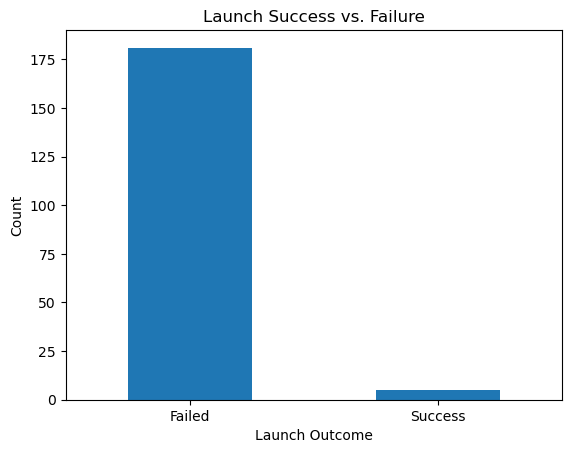

In [72]:
# 1. Plot the count of successful vs. failed launches
success_counts = df_eda['success'].value_counts()
success_counts.plot(kind='bar', title='Launch Success vs. Failure', xlabel='Launch Outcome', ylabel='Count')
plt.xticks(ticks=[0, 1], labels=['Failed', 'Success'], rotation=0)
plt.show()

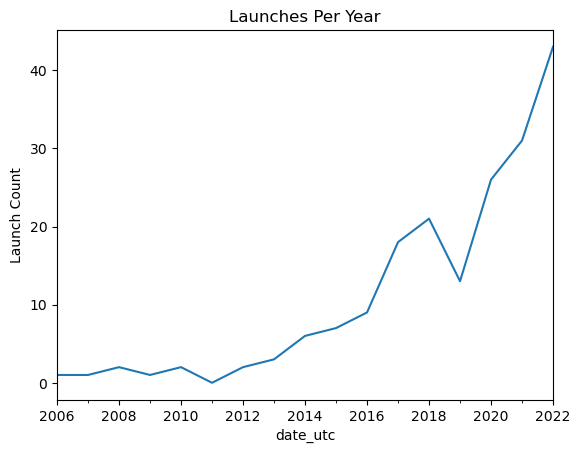

In [73]:
# 2. Plot the number of launches over time
df_eda.set_index('date_utc')['success'].resample('Y').count().plot(title='Launches Per Year', ylabel='Launch Count')
plt.show()

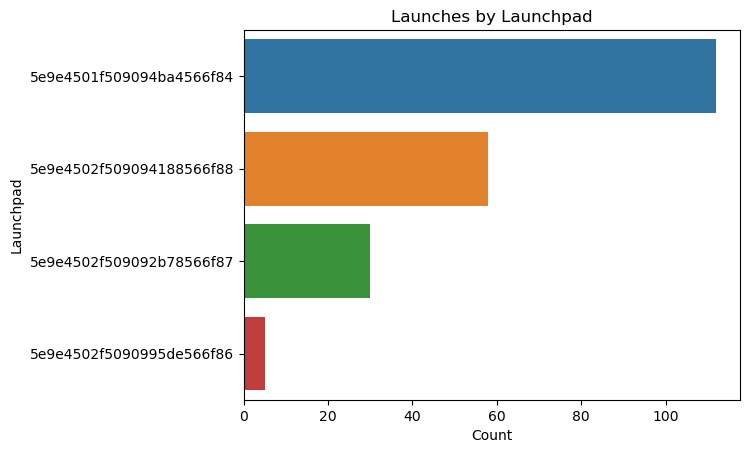

In [74]:
# 3. Use Seaborn to plot the distribution of launches by launchpad
sns.countplot(data=df_eda, y='launchpad', order=df_eda['launchpad'].value_counts().index)
plt.title('Launches by Launchpad')
plt.xlabel('Count')
plt.ylabel('Launchpad')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



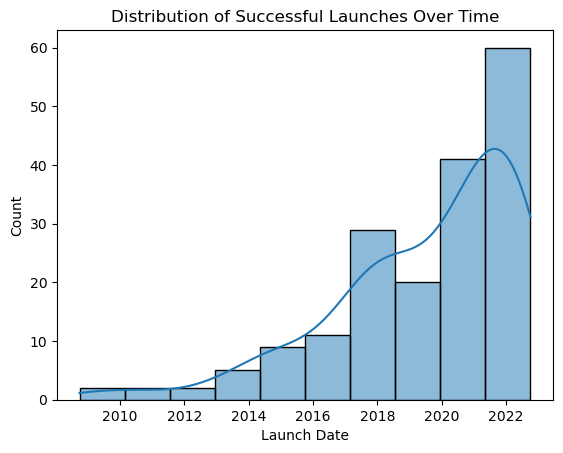

In [75]:
# 4. Example: Filter data for successful launches and visualize them
successful_launches = df_eda[df_eda['success'] == True]
sns.histplot(data=successful_launches, x='date_utc', bins=10, kde=True)
plt.title('Distribution of Successful Launches Over Time')
plt.xlabel('Launch Date')
plt.ylabel('Count')
plt.show()

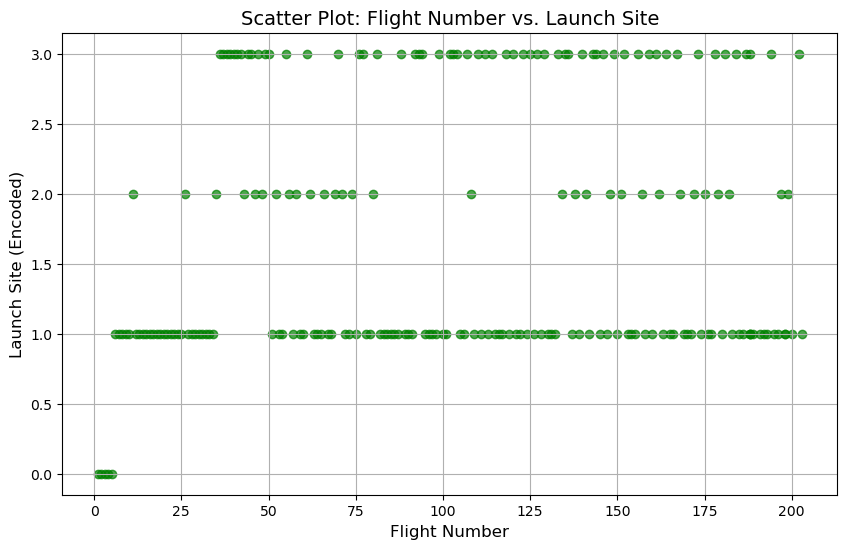

In [91]:
# Scatter plot of Flight Number vs. Launch Site

# Normalize data into a DataFrame
df = pd.json_normalize(launches_data)
df = df[['flight_number', 'launchpad']]

# Encode the launchpad for visualization
df['launchpad'] = pd.factorize(df['launchpad'])[0]

# Scatter plot: Flight Number vs Launch Site
plt.figure(figsize=(10, 6))
plt.scatter(df['flight_number'], df['launchpad'], alpha=0.7, color='green')
plt.title('Scatter Plot: Flight Number vs. Launch Site', fontsize=14)
plt.xlabel('Flight Number', fontsize=12)
plt.ylabel('Launch Site (Encoded)', fontsize=12)
plt.grid(True)
plt.show()


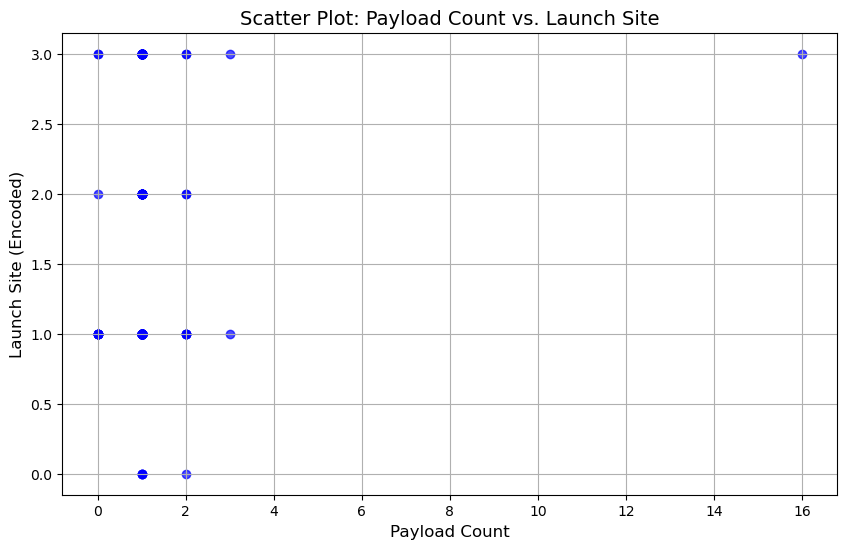

In [92]:
# Scatter plot of Payload Count vs. Launch Site

# Normalize data into a DataFrame
df = pd.json_normalize(launches_data)
df['payload_count'] = df['payloads'].apply(lambda x: len(x) if isinstance(x, list) else 0)
df = df[['payload_count', 'launchpad']]

# Encode the launchpad for visualization
df['launchpad'] = pd.factorize(df['launchpad'])[0]

# Scatter plot: Payload vs Launch Site
plt.figure(figsize=(10, 6))
plt.scatter(df['payload_count'], df['launchpad'], alpha=0.7, color='blue')
plt.title('Scatter Plot: Payload Count vs. Launch Site', fontsize=14)
plt.xlabel('Payload Count', fontsize=12)
plt.ylabel('Launch Site (Encoded)', fontsize=12)
plt.grid(True)
plt.show()

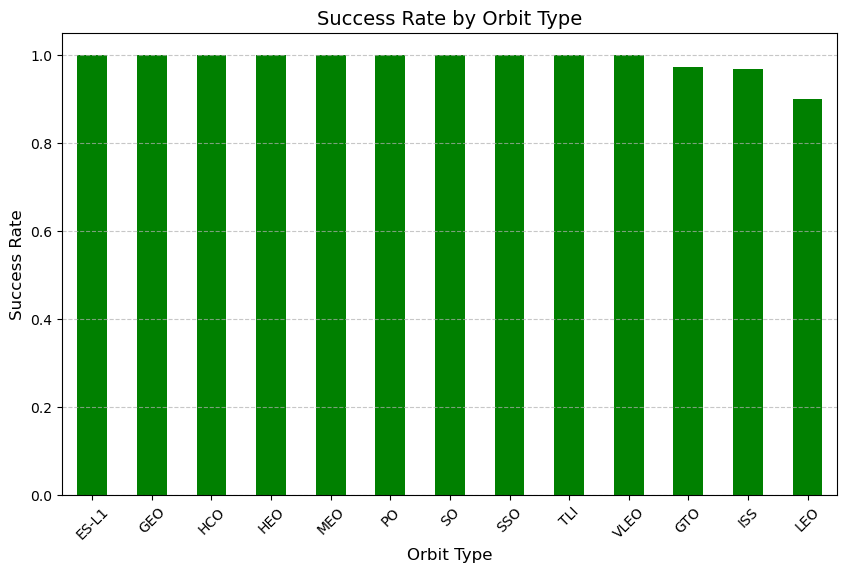

In [95]:
# bar chart for the success rate of each orbit type

# Fetch SpaceX data
base_url = "https://api.spacexdata.com/v4"
launches_url = f"{base_url}/launches"
response = requests.get(launches_url)
launches_data = response.json()

# Normalize data into a DataFrame
df = pd.json_normalize(launches_data)
df_orbit = df[['payloads', 'success']]

# Fetch payload data to get orbit type
payloads_url = f"{base_url}/payloads"
payloads_response = requests.get(payloads_url)
payloads_data = pd.json_normalize(payloads_response.json())

# Merge payloads data with launches to get orbit type
df_orbit = df_orbit.explode('payloads').merge(payloads_data[['id', 'orbit']], left_on='payloads', right_on='id', how='left')
df_orbit = df_orbit[['orbit', 'success']]

# Calculate success rate for each orbit
success_rate = df_orbit.groupby('orbit')['success'].mean().sort_values(ascending=False)

# Bar chart for success rate of each orbit type
plt.figure(figsize=(10, 6))
success_rate.plot(kind='bar', color='green')
plt.title('Success Rate by Orbit Type', fontsize=14)
plt.xlabel('Orbit Type', fontsize=12)
plt.ylabel('Success Rate', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

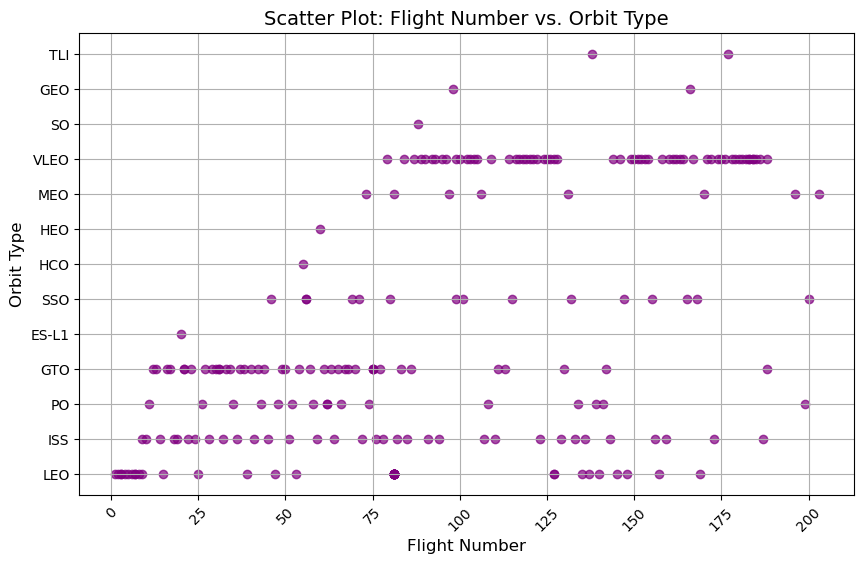

In [96]:
# scatter point of Flight number vs. Orbit type

# Normalize data into a DataFrame
df = pd.json_normalize(launches_data)
df_orbit = df[['flight_number', 'payloads']]

# Fetch payload data to get orbit type
payloads_url = f"{base_url}/payloads"
payloads_response = requests.get(payloads_url)
payloads_data = pd.json_normalize(payloads_response.json())

# Merge payloads data with launches to get orbit type
df_orbit = df_orbit.explode('payloads').merge(payloads_data[['id', 'orbit']], left_on='payloads', right_on='id', how='left')
df_orbit = df_orbit[['flight_number', 'orbit']]

# Drop rows with missing orbit values
df_orbit = df_orbit.dropna(subset=['orbit'])

# Scatter plot: Flight Number vs Orbit Type
plt.figure(figsize=(10, 6))
plt.scatter(df_orbit['flight_number'], df_orbit['orbit'], alpha=0.7, color='purple')
plt.title('Scatter Plot: Flight Number vs. Orbit Type', fontsize=14)
plt.xlabel('Flight Number', fontsize=12)
plt.ylabel('Orbit Type', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

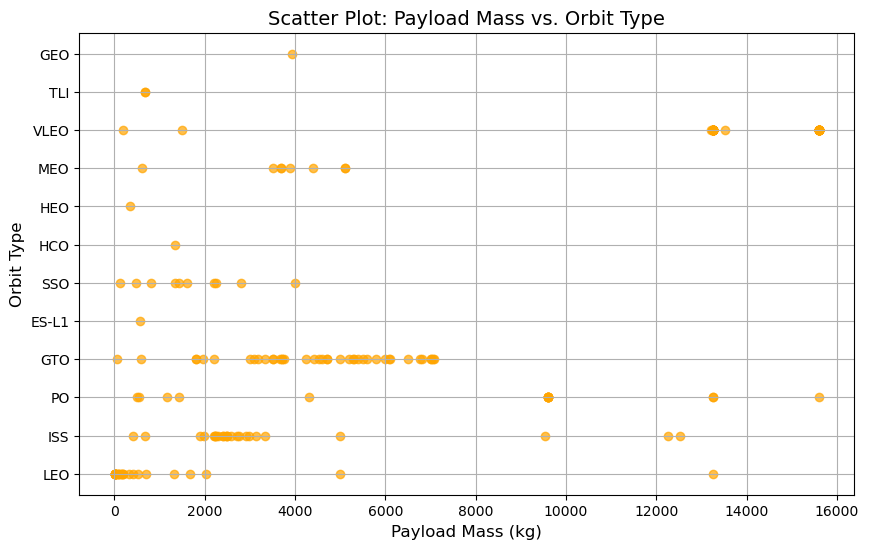

In [97]:
# scatter point of payload vs. orbit type

# Normalize data into a DataFrame
df = pd.json_normalize(launches_data)
df_payloads = df[['payloads']].explode('payloads')

# Fetch payload data to get orbit type and payload mass
payloads_url = f"{base_url}/payloads"
payloads_response = requests.get(payloads_url)
payloads_data = pd.json_normalize(payloads_response.json())

# Merge payload data to get orbit type and payload mass
df_payloads = df_payloads.merge(payloads_data[['id', 'orbit', 'mass_kg']], left_on='payloads', right_on='id', how='left')
df_payloads = df_payloads[['orbit', 'mass_kg']]

# Drop rows with missing payload mass or orbit values
df_payloads = df_payloads.dropna(subset=['orbit', 'mass_kg'])

# Scatter plot: Payload Mass vs Orbit Type
plt.figure(figsize=(10, 6))
plt.scatter(df_payloads['mass_kg'], df_payloads['orbit'], alpha=0.7, color='orange')
plt.title('Scatter Plot: Payload Mass vs. Orbit Type', fontsize=14)
plt.xlabel('Payload Mass (kg)', fontsize=12)
plt.ylabel('Orbit Type', fontsize=12)
plt.grid(True)
plt.show()

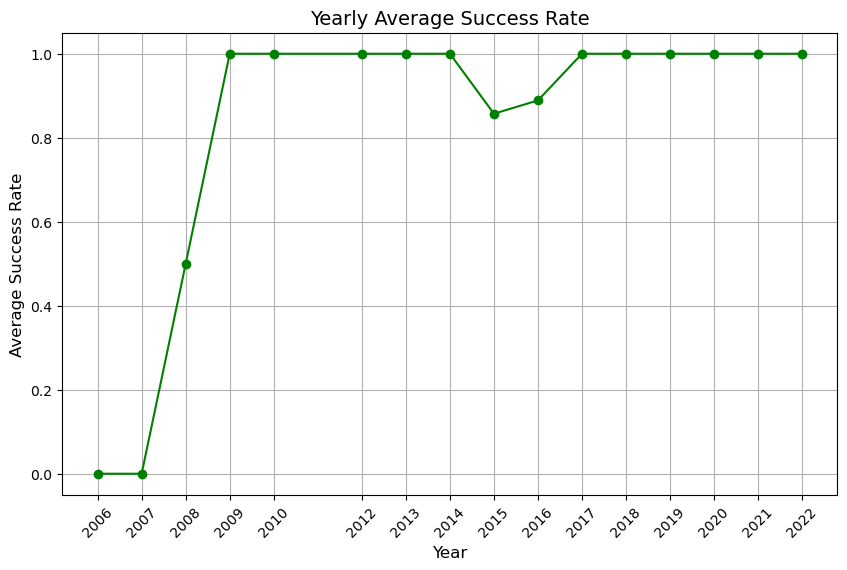

In [98]:
# line chart of yearly average success rate

# Normalize data into a DataFrame
df = pd.json_normalize(launches_data)
df['date_utc'] = pd.to_datetime(df['date_utc'])
df['year'] = df['date_utc'].dt.year

# Calculate yearly average success rate
yearly_success_rate = df.groupby('year')['success'].mean()

# Line chart: Yearly Average Success Rate
plt.figure(figsize=(10, 6))
plt.plot(yearly_success_rate.index, yearly_success_rate.values, marker='o', linestyle='-', color='green')
plt.title('Yearly Average Success Rate', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Success Rate', fontsize=12)
plt.grid(True)
plt.xticks(yearly_success_rate.index, rotation=45)
plt.show()

In [76]:
# Explore Rocket Names (Additional API Call)
rockets_url = f"{base_url}/rockets"
response_rockets = requests.get(rockets_url)

if response_rockets.status_code == 200:
    rockets_data = response_rockets.json()
    rocket_df = pd.json_normalize(rockets_data)
    # Map rocket names to the main dataframe using rocket IDs
    rocket_dict = rocket_df.set_index('id')['name'].to_dict()
    df_eda['rocket_name'] = df_eda['rocket'].map(rocket_dict)
    print("Rocket names added to the dataset.")
else:
    print("Failed to fetch rocket data.")

# View the enriched dataset
print(df_eda[['name', 'rocket_name', 'success']].head())


Rocket names added to the dataset.
          name rocket_name success
0    FalconSat    Falcon 1   False
1      DemoSat    Falcon 1   False
2  Trailblazer    Falcon 1   False
3       RatSat    Falcon 1    True
4     RazakSat    Falcon 1    True


/var/folders/0n/7zh_5ys15qg_3mxxvd5rmfhh0000gn/T/ipykernel_6420/3848858824.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## SQL Queries

In [100]:
# Normalize and Prepare Data
df = pd.json_normalize(launches_data)
df = df[['flight_number', 'name', 'payloads', 'rocket', 'launchpad', 'success', 'date_utc']]


# Transform payloads: count the number of payloads in each launch
df['payload_count'] = df['payloads'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Drop the original payloads column (if not needed for the query)
df = df.drop(columns=['payloads'])


In [101]:
# Step 3: Create SQLite Database and Load Data
conn = sqlite3.connect(':memory:')  # In-memory DB
df.to_sql('SPACEXTBL', conn, index=False, if_exists='replace')  # Load table

205

In [102]:
# Query 1: Select first 20 rows
query1 = 'SELECT * FROM SPACEXTBL LIMIT 20'
result1 = pd.read_sql_query(query1, conn)
print("Query 1: First 20 Rows")
print(result1)

Query 1: First 20 Rows
    flight_number                  name                    rocket  \
0               1             FalconSat  5e9d0d95eda69955f709d1eb   
1               2               DemoSat  5e9d0d95eda69955f709d1eb   
2               3           Trailblazer  5e9d0d95eda69955f709d1eb   
3               4                RatSat  5e9d0d95eda69955f709d1eb   
4               5              RazakSat  5e9d0d95eda69955f709d1eb   
5               6  Falcon 9 Test Flight  5e9d0d95eda69973a809d1ec   
6               7                COTS 1  5e9d0d95eda69973a809d1ec   
7               8                COTS 2  5e9d0d95eda69973a809d1ec   
8               9                 CRS-1  5e9d0d95eda69973a809d1ec   
9              10                 CRS-2  5e9d0d95eda69973a809d1ec   
10             11              CASSIOPE  5e9d0d95eda69973a809d1ec   
11             12                 SES-8  5e9d0d95eda69973a809d1ec   
12             13             Thaicom 6  5e9d0d95eda69973a809d1ec   
13         

In [103]:
# Query 2: Get total launches with payloads
query2 = '''
SELECT COUNT(payload_count) AS Total_Launches, launchpad
FROM SPACEXTBL
GROUP BY launchpad
'''
result2 = pd.read_sql_query(query2, conn)
print("\nQuery 2: Total Payload Mass")
print(result2)


Query 2: Total Payload Mass
   Total_Launches                 launchpad
0             112  5e9e4501f509094ba4566f84
1              30  5e9e4502f509092b78566f87
2              58  5e9e4502f509094188566f88
3               5  5e9e4502f5090995de566f86


In [104]:

# Query 3: Success/Failure breakdown
query3 = '''
SELECT success as success_failures, COUNT(*)
FROM SPACEXTBL
GROUP BY success
'''
result3 = pd.read_sql_query(query3, conn)
print("\nQuery 3: Count of successful launches")
print(result3)


Query 3: Count of successful launches
   success_failures  COUNT(*)
0               NaN        19
1               0.0         5
2               1.0       181


In [105]:
# Query 4: Year-wise launches
query4 = '''
SELECT COUNT(flight_number) as yearly_flights, date(date_utc) as launch_year
FROM SPACEXTBL
GROUP BY strftime('%Y', date_utc)
ORDER BY date_utc ASC
'''
result4 = pd.read_sql_query(query4, conn)
print("\nQuery 4: Launchpad stats")
print(result4)




Query 4: Launchpad stats
    yearly_flights launch_year
0                1  2006-03-24
1                1  2007-03-21
2                2  2008-08-03
3                1  2009-07-13
4                2  2010-06-04
5                2  2012-05-22
6                3  2013-03-01
7                6  2014-01-06
8                7  2015-01-10
9                9  2016-01-17
10              18  2017-01-14
11              21  2018-01-08
12              13  2019-01-11
13              26  2020-01-07
14              31  2021-01-08
15              62  2022-01-06


In [106]:
# Query 5: SQL query to find all the unique launch sites
query = "SELECT DISTINCT launchpad FROM SPACEXTBL;"
unique_launch_sites = pd.read_sql_query(query, conn)
print("Unique Launch Sites:")
print(unique_launch_sites)

Unique Launch Sites:
                  launchpad
0  5e9e4502f5090995de566f86
1  5e9e4501f509094ba4566f84
2  5e9e4502f509092b78566f87
3  5e9e4502f509094188566f88


In [110]:
# Query to find 5 records where launch sites begin with CCA
query = "SELECT * FROM SPACEXTBL WHERE launchpad LIKE 'CCA%' LIMIT 5;"
result = pd.read_sql_query(query, conn)

print("Query Result:")
print(result)

Query Result:
Empty DataFrame
Columns: [flight_number, mission_name, rocket, launchpad, success, date_utc, id, launchpad_name]
Index: []


In [83]:
# Close the connection
conn.close()

## Interactive Map with Folium

In [136]:
# Step 1: Create a base map
# Centered at Cape Canaveral, approximate coordinates
map_center = [28.5623, -80.5774]  # Cape Canaveral
spacex_map = folium.Map(location=map_center, zoom_start=10)

# Step 2: Add markers for SpaceX launch sites
launch_sites = [
    {"name": "CCAFS SLC-40", "coords": [28.562302, -80.577356]},
    {"name": "KSC LC-39A", "coords": [28.573255, -80.646895]},
    {"name": "VAFB SLC-4E", "coords": [34.632093, -120.610829]},
    {"name": "STLS", "coords": [25.997264, -97.156084]}  # Boca Chica (Starbase)
]

# Add markers with popups
for site in launch_sites:
    folium.Marker(
        location=site["coords"],
        popup=f"{site['name']}",
        tooltip="Click for info",
        icon=folium.Icon(color="blue", icon="rocket", prefix="fa")
    ).add_to(spacex_map)


# Add HeatMap layer
heatmap_data = [site["coords"] for site in launch_sites]
HeatMap(heatmap_data).add_to(spacex_map)

# Step 3: Add a layer control
folium.LayerControl().add_to(spacex_map)

# Step 4: Display the map
spacex_map.save("spacex_launch_sites.html")
spacex_map


## Dashboard with Plotly Dash


In [139]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import pandas as pd
import plotly.express as px
import requests

# Fetch SpaceX data
base_url = "https://api.spacexdata.com/v4"
launches_url = f"{base_url}/launches"
payloads_url = f"{base_url}/payloads"

response_launches = requests.get(launches_url)
response_payloads = requests.get(payloads_url)

launches_data = response_launches.json()
payloads_data = pd.json_normalize(response_payloads.json())

# Normalize and clean data
df = pd.json_normalize(launches_data)
df['date_utc'] = pd.to_datetime(df['date_utc'])
df = df[['flight_number', 'name', 'date_utc', 'success', 'rocket', 'launchpad', 'payloads']]

# Explode payloads and merge with payload data for mass
df = df.explode('payloads').merge(payloads_data[['id', 'mass_kg']], left_on='payloads', right_on='id', how='left')

# Initialize Dash app
app = dash.Dash(__name__)

# Define Layout
app.layout = html.Div([
    html.H1("SpaceX Launch Dashboard", style={'textAlign': 'center'}),
    
    dcc.Dropdown(
        id='launch-site-dropdown',
        options=[
            {'label': 'All Sites', 'value': 'ALL'},
            {'label': 'CCAFS SLC-40', 'value': '5e9e4502f509094ba4566f84'},
            {'label': 'KSC LC-39A', 'value': '5e9e4502f509094ba4566f87'},
            {'label': 'VAFB SLC-4E', 'value': '5e9e4501f509094ba4566f83'},
            {'label': 'STLS', 'value': '5e9e4503f509094ba4566f88'}
        ],
        value='ALL',  # Default value
        placeholder='Select a Launch Site',
        style={'width': '50%'}
    ),
    
    html.Div([
        dcc.Graph(id='success-pie-chart', style={'display': 'inline-block', 'width': '49%'}),
        dcc.Graph(id='launch-trend-line-chart', style={'display': 'inline-block', 'width': '49%'}),
        dcc.Graph(id='payload-outcome-scatter', style={'width': '100%'})
    ])
])

# Define Callbacks
@app.callback(
    [Output('success-pie-chart', 'figure'),
     Output('launch-trend-line-chart', 'figure'),
     Output('payload-outcome-scatter', 'figure')],
    [Input('launch-site-dropdown', 'value')]
)
def update_charts(selected_site):
    if selected_site == 'ALL':
        filtered_df = df
        pie_fig = px.pie(df, names='success', title='Overall Success Rate')
    else:
        filtered_df = df[df['launchpad'] == selected_site]
        pie_fig = px.pie(filtered_df, names='success', title=f'Success Rate for Site {selected_site}')
    
    # Line chart for launch trends
    line_fig = px.line(
        filtered_df, 
        x='date_utc', 
        y='flight_number', 
        title='Launch Trend Over Time',
        labels={'flight_number': 'Flight Number'}
    )
    
    # Scatter plot for Payload vs Launch Outcome
    scatter_fig = px.scatter(
        filtered_df,
        x='mass_kg',
        y='success',
        title='Payload vs. Launch Outcome',
        labels={'mass_kg': 'Payload Mass (kg)', 'success': 'Launch Outcome'},
        color='success',
        hover_data=['name']
    )
    
    return pie_fig, line_fig, scatter_fig

# Run the App
if __name__ == '__main__':
    app.run_server(debug=True)


/opt/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/opt/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/opt/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/opt/anaconda3/lib/python3.1

## Predictive Analysis (Classification)

The objective is to establish a machine learning model to predict the future landing success of rocket launches given on the history of success data

In [141]:
# Fetch and Prepare Data
base_url = "https://api.spacexdata.com/v4"
launches_url = f"{base_url}/launches"
response = requests.get(launches_url)
launches_data = response.json()

df = pd.json_normalize(launches_data)
df = df[['flight_number', 'rocket', 'launchpad', 'payloads', 'success', 'date_utc']]
df['payload_count'] = df['payloads'].apply(lambda x: len(x) if isinstance(x, list) else 0)

df = df.drop(columns=['date_utc', 'payloads'])
df = df.dropna(subset=['success'])  # Drop rows with missing success values

# Drop rows with missing success values
df = df.dropna(subset=['success'])  

# Encode categorical variables
df['rocket'] = pd.factorize(df['rocket'])[0]
df['launchpad'] = pd.factorize(df['launchpad'])[0]

# Step 2: Feature Selection
X = df[['flight_number', 'rocket', 'launchpad', 'payload_count']]
y = df['success'].astype(int)

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Normalize Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 5: Train a Random Forest Classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

# Step 6: Make Predictions
y_pred = classifier.predict(X_test)

# Step 7: Evaluate the Model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))


Confusion Matrix:
[[ 0  0]
 [ 1 37]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.97      0.99        38

    accuracy                           0.97        38
   macro avg       0.50      0.49      0.49        38
weighted avg       1.00      0.97      0.99        38


Accuracy Score:
0.9736842105263158


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



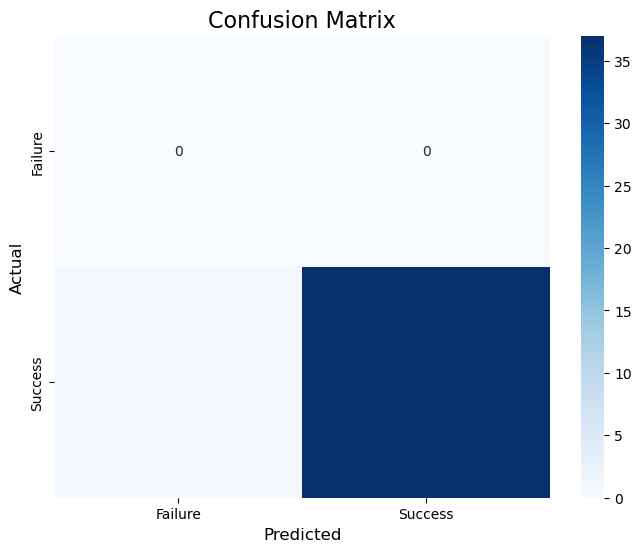

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning:

No negative samples in y_true, false positive value should be meaningless



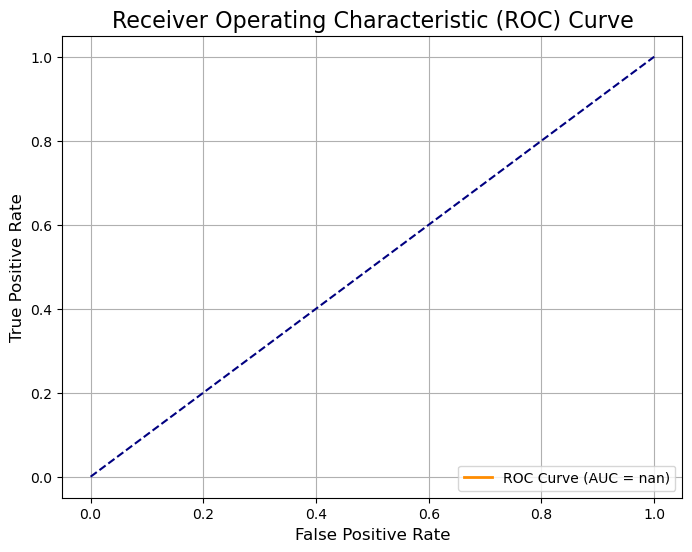

In [144]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Failure', 'Success'], yticklabels=['Failure', 'Success'])
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.show()

# Calculate ROC Curve and AUC
y_prob = classifier.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc='lower right')
plt.grid()
plt.show()


## Analysis of Results:

- High Accuracy: The model achieved an accuracy score of 97.37%, indicating that it correctly predicted the outcome for most test samples.
- Imbalanced Data: The confusion matrix shows that all predictions were for the "success" class (1), with no predictions for the "failure" class (0). This suggests the dataset might be heavily skewed toward successful launches, leading to poor generalization for failures.
- Precision and Recall: Precision for success (1.00): Every predicted success was correct.
- Recall for success (0.97): Almost all actual successes were identified, but failures were not captured.

## Key Takeaways:
- Imbalanced Dataset: The model struggles to predict failures (class 0) due to their absence in the test set. Precision and recall for the failure class are 0.00, indicating no ability to predict failures.